# The U.S. Senate #

In [58]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import datetime
import pandas as pd
import operator

import sys
sys.path.append('../data')

import congress_db
from setup_db import Candidate, Contribution, Committee
from sqlalchemy import func

session = congress_db.create_session()

df = pd.read_csv('../data/rollCallVotes_cleaned.csv')
only_bills = df[df['voteResult'].isin(['Amendment Rejected', 'Amendment Agreed to', 'Bill Passed', 'Bill Defeated', 
                          'Concurrent Resolution Agreed to', 'Concurrent Resolution Rejected', 
                          'Joint Resolution Passed', 'Joint Resolution Defeated'])].reset_index()

## Party Contributions over an Election Cycle ##

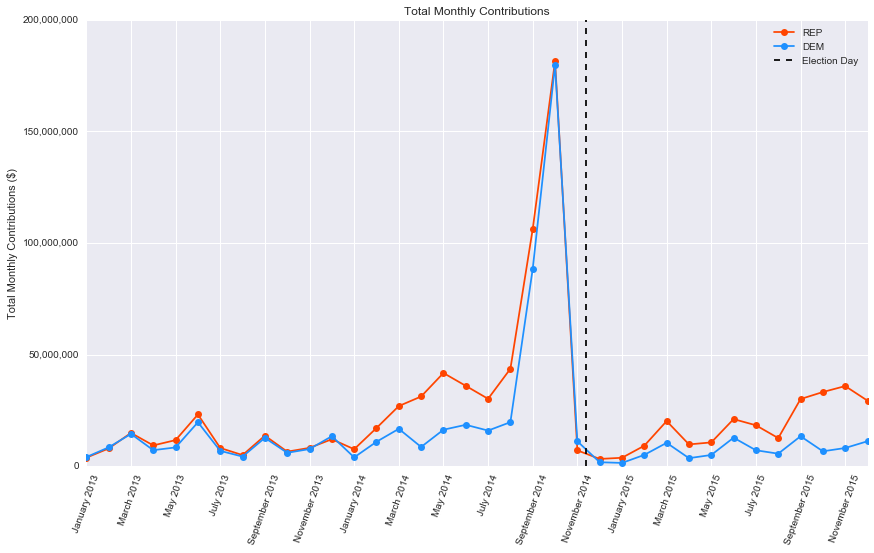

In [59]:
import contributions

plt.figure(figsize=(14, 8))
contributions.plot_monthly_dollars_by_party('REP', color='orangered')
contributions.plot_monthly_dollars_by_party('DEM', color='dodgerblue', election_date=datetime.date(2014, 11, 4))
plt.show()

## Party Sponsorship Breakdown (Pie chart of party sponsorship breakdown) ##


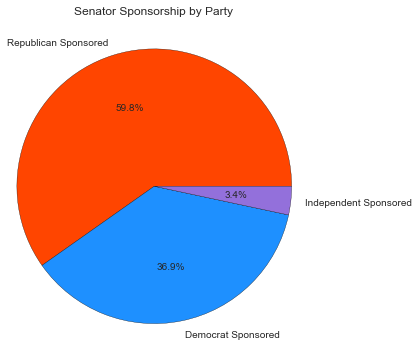

In [57]:
rep_count = 0
dem_count = 0
ind_count = 0
for sponsor in only_bills.sponsor:
    if sponsor.split()[1][1] == 'R':
        rep_count += 1
    elif sponsor.split()[1][1] == 'D':
        dem_count += 1
    elif sponsor.split()[1][1] == 'I':
        ind_count += 1
res = [float(rep_count)/len(only_bills), float(dem_count)/len(only_bills), float(ind_count)/len(only_bills)]
fig = plt.figure(figsize=(5,5))
plt.pie([res[0]*100, res[1]*100, res[2]*100],
        labels=['Republican Sponsored', 'Democrat Sponsored', 'Independent Sponsored'],
        colors=['orangered', 'dodgerblue', 'mediumpurple'],autopct='%1.1f%%')
plt.axis('equal')
plt.title('Senator Sponsorship by Party',  y=1.1)
plt.show()

## Party sponsored legislation status (pass/fail) ##

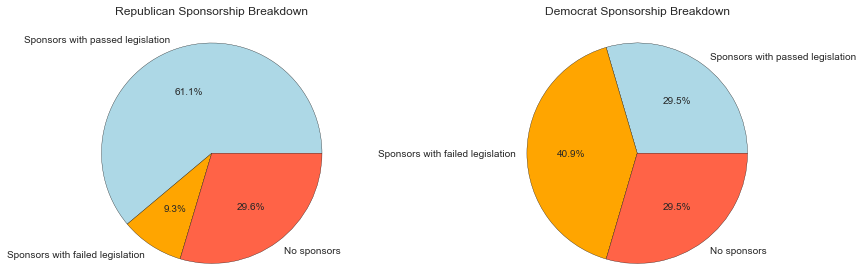

In [54]:
senators = df.ix[:,0:100]
dems = [col for col in senators.columns if col.split()[1][1] == 'D']
reps = [col for col in senators.columns if col.split()[1][1] == 'R']
independents = [col for col in senators.columns if col.split()[1][1] == 'I']    

def sponsor_effectiveness(senator):
    sponsored_bills = only_bills[only_bills.sponsor == senator].reset_index()
    count = 0
    for i in range(0, len(sponsored_bills.voteResult)):
        if any(word in sponsored_bills.voteResult[i] for word in ['Agreed to', 'Passed']):
            count += 1
    if len(sponsored_bills.voteResult):
        return float(count) / len(sponsored_bills.voteResult)
    else:
        return None

def sponsor_breakdown(sen_list, title, pos):
    bills_passed = 0
    bills_failed = 0
    no_sponsors = 0
    for senator in sen_list:
        percentage_passed = sponsor_effectiveness(senator)
        if percentage_passed:
            bills_passed += 1
        elif percentage_passed == 0:
            bills_failed += 1
        else:
            no_sponsors += 1
    res = [float(bills_passed)/len(sen_list), float(bills_failed)/len(sen_list), float(no_sponsors)/len(sen_list)]
    plt.subplot(1, 2, pos)
    plt.pie([res[0]*100, res[1]*100, res[2]*100],
            labels=['Sponsors with passed legislation', 'Sponsors with failed legislation', 'No sponsors'],
            colors=['lightblue', 'orange', 'tomato'],autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(title,  y=1.1)
    return


plt.figure(figsize=(14,4))
sponsor_breakdown(reps, 'Republican Sponsorship Breakdown', 1)
sponsor_breakdown(dems, 'Democrat Sponsorship Breakdown', 2)
plt.show()

## Top Contributors to each Party ##

In [5]:
import datetime

def top_contributors_by_party(party):
    return session.query(func.sum(Contribution.tx_amount).label('total_cont'), Committee.name).\
                filter(Contribution.tx_date > datetime.date(2012, 11, 4)).\
                join(Committee).\
                filter(Committee.committee_type.in_('CDEINOPQUVWXYZ')).\
                filter(Committee.designation != 'P').\
                join(Candidate).\
                filter(Candidate.party == party).\
                group_by(Contribution.committee_id).\
                order_by('total_cont desc').\
                all()
                
def plot_top_contributors_by_party(party):
    dollars, committees = zip(*top_contributors_by_party(party))

    plt.figure(figsize=(12, 10))
    sns.barplot(dollars[:20], committees[:20], ci=None)
    
    # format for dollars
    a = plt.gca()
    a.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.xlabel('Total Contributions ($)')
    plt.title('Top Committees contributing to ' + party + ' party')
    plt.show()

//anaconda/lib/python2.7/site-packages/sqlalchemy/sql/compiler.py:572: SAWarning: Can't resolve label reference 'total_cont desc'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))
//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


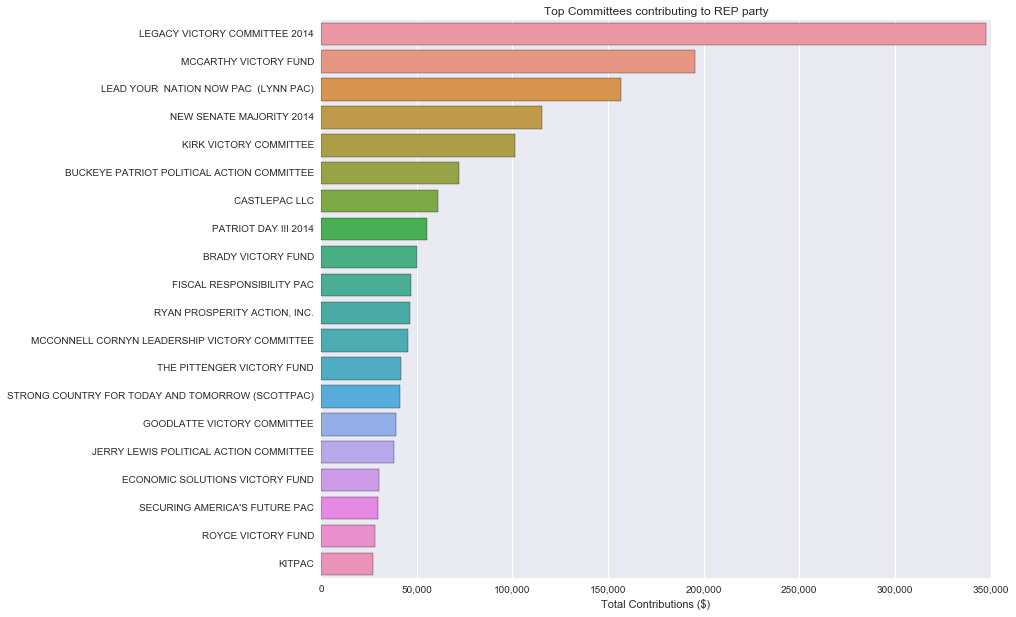

In [6]:
plot_top_contributors_by_party('REP')

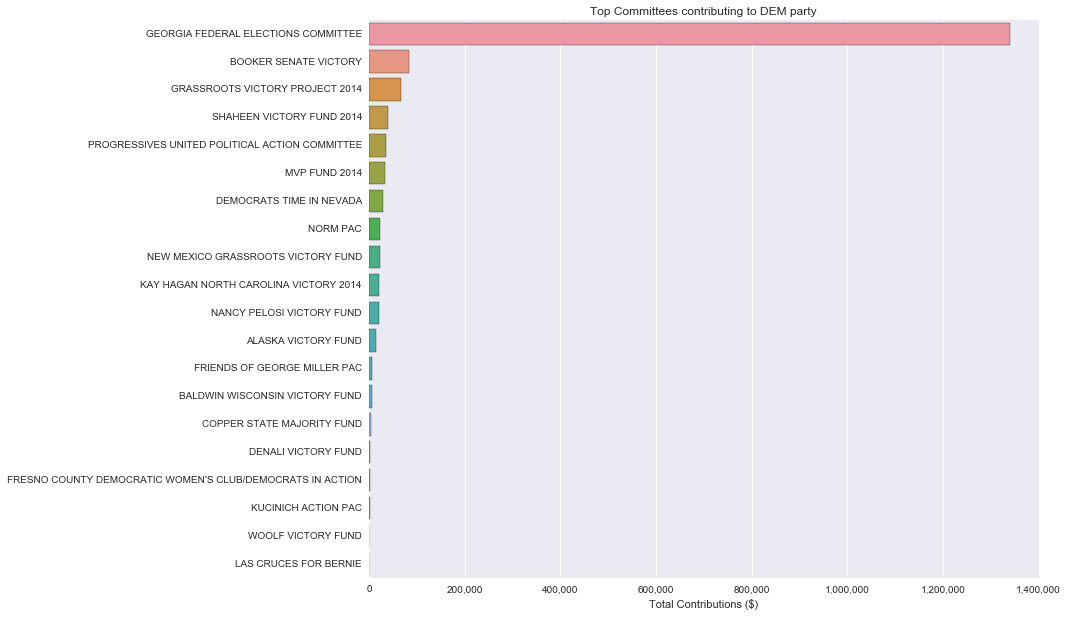

In [7]:
plot_top_contributors_by_party('DEM')

## Top senator sponsors ##

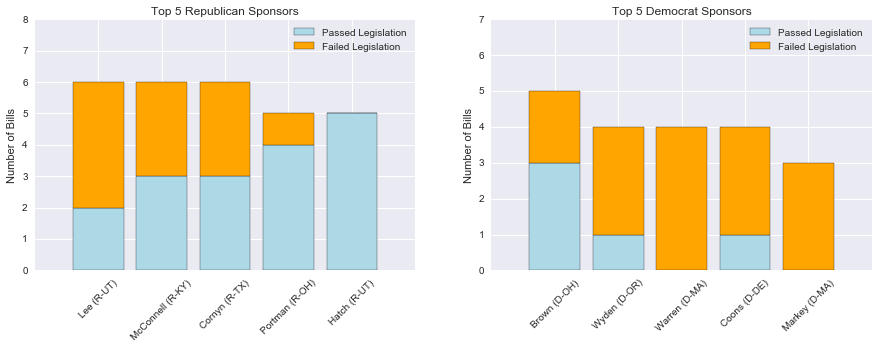

In [51]:
sponsored_no = {}
for sponsor in only_bills.sponsor:
    if sponsor in sponsored_no:
        sponsored_no[sponsor] += 1
    else:
        sponsored_no[sponsor] = 1

sorted_sponsored_no = sorted(sponsored_no.items(), key=operator.itemgetter(1))[::-1]
rep_sponsors = [sponsor for sponsor in sorted_sponsored_no if sponsor[0].split()[1][1] == 'R']
dem_sponsors = [sponsor for sponsor in sorted_sponsored_no if sponsor[0].split()[1][1] == 'D']

def top_sponsor_effectiveness(sponsor_list, title, pos):
    sen_list = [sponsor[0] for sponsor in sponsor_list[0:5]]
    tot_bills = [sponsor[1] for sponsor in sponsor_list[0:5]]
    successes = []
    fails = []
    for sponsor in sen_list:
        success = 0
        fail = 0
        for result in only_bills[only_bills.sponsor == sponsor].voteResult:
            if any(word in result for word in ['Agreed to', 'Passed']):
                success += 1
            elif any(word in result for word in ['Rejected', 'Failed']):
                fail += 1
        if success + fail != len(only_bills[only_bills.sponsor == sponsor]):
            print "Aw man something is blazed"
        else:
            successes.append(success)
            fails.append(fail)
#     plt.figure(figsize=(8,5))
    plt.subplot(1, 2, pos)
    p1 = plt.bar(range(len(successes)), successes, align='center', color='lightblue')
    p2 = plt.bar(range(len(fails)), fails, align='center', color='orange', bottom=successes)
    plt.axis([-1, len(sen_list), 0, max(tot_bills)+2])
    plt.xticks(range(len(sen_list)), sen_list, rotation=45)
    plt.title(title)
    plt.ylabel('Number of Bills')
    plt.legend((p1[0], p2[0]), ('Passed Legislation', 'Failed Legislation'))
    return 

plt.figure(figsize=(15,4.5))
top_sponsor_effectiveness(rep_sponsors, 'Top 5 Republican Sponsors', 1)
top_sponsor_effectiveness(dem_sponsors, 'Top 5 Democrat Sponsors', 2)
plt.show()

In [9]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

topics = list(df.columns[105:-2].values)

def topic_search1(query):
    found_topics = []
    for topic in topics:
        if query.lower() in topic.lower():
            found_topics.append(topic)

    topics_drop_widget1.options = found_topics

def topic_search_for_widget1(widget):
    try:
        query = widget['new']['value']
        topic_search(query)
    except:
        pass
    
topic_search_widget1 = widgets.Text(
    description='Search:',
    value='Immigration'
)

topic_search_widget1.observe(topic_search_for_widget1)

topics_drop_widget1 = widgets.Dropdown(
    options=topics,
    description=' ',
)

topic_search1(topic_search_widget1.value)

display(topic_search_widget1)
display(topics_drop_widget1)

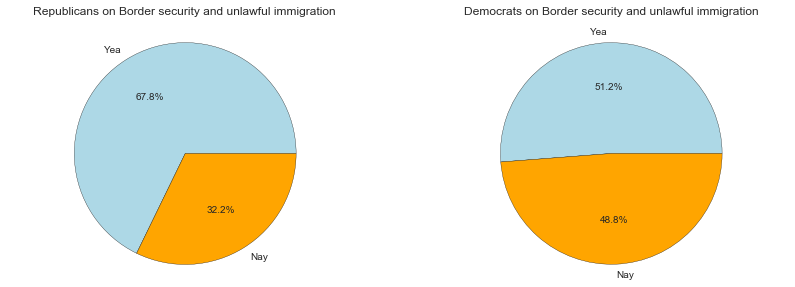

In [50]:
def votes_on_subject(senator, subject):
    subject_df = df[df[subject] == 1]
    senator_subject = subject_df[senator]
    yeas = len(senator_subject[senator_subject == 'Yea'])
    nays = len(senator_subject[senator_subject == 'Nay'])
    if (yeas + nays):
        percent_voted_yea = float(yeas) / (yeas + nays)
        return percent_voted_yea
    else:
        return None

def party_votes_on_subject(sen_list, subject, party, pos):
    tot = 0
    for senator in sen_list:
        if votes_on_subject(senator, subject):
            tot += votes_on_subject(senator, subject)
    avg_voted_yea = tot / len(sen_list)
    labels = 'Yea', 'Nay'
    colors = ['lightblue', 'orange']
    plt.subplot(1, 2, pos)
    plt.pie([avg_voted_yea*100, 100 - avg_voted_yea*100],
            labels=labels, colors=colors, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(party + " on " + subject, y=1.1)
    return

plt.figure(figsize=(14,4))
party_votes_on_subject(reps, topics_drop_widget1.value, 'Republicans', 1)  
party_votes_on_subject(dems, topics_drop_widget1.value, 'Democrats', 2)  

# Investigate your Senators #

In [17]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

senator_names = list(df.columns[:100].values)

senator_search_widget = widgets.Text(
    description='Search:',
    value='Warren'
)

senator_widget = widgets.Dropdown(
    options=senator_names,
    description=' ',
)

def search_senator_for_widget(widget):
    try:
        query = widget['new']['value']
        search_senator(query)
    except:
        pass

def search_senator(query):
    found_senators = []
    for senator in senator_names:
        if query.lower() in senator.lower():
            found_senators.append(senator)
    senator_widget.options = found_senators

senator_search_widget.observe(search_senator_for_widget)

search_senator(senator_search_widget.value)

display(senator_search_widget)
display(senator_widget)

In [49]:
import re
def get_senator_id(Senator):
    parts = re.split('[ ()-]+', Senator)
    last_name = parts[0]
    party_letter = parts[1]
    state = parts[2]
    
    id = session.query(Candidate.id).\
            filter(Candidate.office_st == state).\
            filter(Candidate.name.like('%' + last_name + '%')).\
            filter(Candidate.party.like(party_letter + '%')).\
            filter(Candidate.office=='S').\
            order_by('Candidate.id desc').\
            first()[0]
    return id

senator_name = senator_widget.value
senator_id = get_senator_id(senator_name)

## Senator Profile ##

In [35]:
senator_info = session.query(Candidate.name, Candidate.office_st, Candidate.party).\
                        filter(Candidate.id == senator_id).\
                        first()
        
full_name, state, party = senator_info

html_str = '<h1>%s</h1><h2>%s - %s</h2>' % (full_name, party, state)
html = widgets.HTML(
    value=html_str
)
display(html)

## Top Contributors ##

In [46]:
def committee_total_contributions(senator_id):
    return session.query(func.sum(Contribution.tx_amount).label('total_cont'), Committee.name).\
                filter(Contribution.candidate_id == senator_id).\
                join(Committee).\
                group_by(Contribution.committee_id).\
                order_by('total_cont desc').\
                all()
                
def plot_interest_groups(cand_id, name=None):
    contr = committee_total_contributions(cand_id)
    amounts, committees = zip(*contr)
    
    plt.figure(figsize=(10, 7))
    sns.barplot(amounts[:5], committees[:5], ci=None)
    plt.xlabel('Contribution ($)')
    
    # format for dollars
    a = plt.gca()
    a.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    if name:
        plt.title('Top contributors to ' + name)

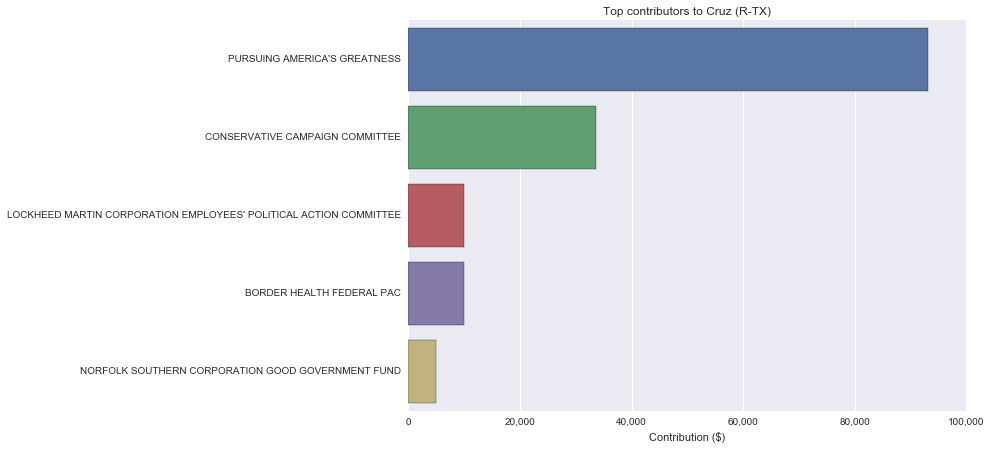

In [47]:
plot_interest_groups(senator_id, senator_name)

## Select a voting Topic ##

In [44]:
topics = list(df.columns[105:].values)

def topic_search(query):
    found_topics = []
    for topic in topics:
        if query.lower() in topic.lower():
            found_topics.append(topic)

    topics_drop_widget.options = found_topics

def topic_search_for_widget(widget):
    try:
        query = widget['new']['value']
        topic_search(query)
    except:
        pass
    
topic_search_widget = widgets.Text(
    description='Search:',
    value='Immigration'
)

topic_search_widget.observe(topic_search_for_widget)

topics_drop_widget = widgets.Dropdown(
    options=topics,
    description=' ',
)

topic_search(topic_search_widget.value)

display(topic_search_widget)
display(topics_drop_widget)

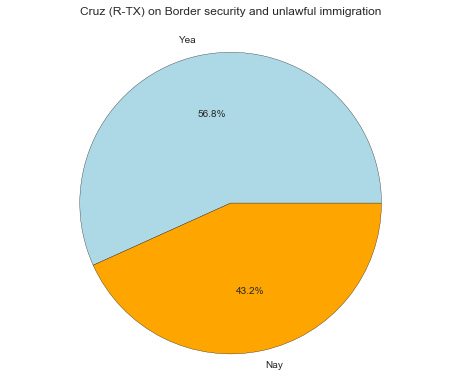

In [45]:
topic = topics_drop_widget.value

percent_voted_yea = votes_on_subject(senator_name, topic)
if percent_voted_yea:
    labels = 'Yea', 'Nay'
    colors = ['lightblue', 'orange']
    plt.pie([percent_voted_yea*100, 100 - percent_voted_yea*100],
                labels=labels, colors=colors, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(senator_name + " on " + topic, y=1.1)
    plt.show()
else:
    print senator_name + " was not present for votes on " + topic

## Sponsorship record (pass/fail) ##

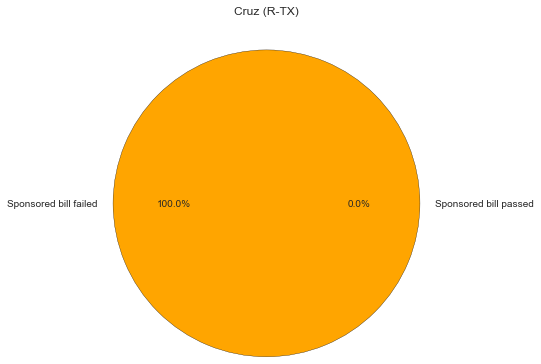

In [41]:
percent_passed = sponsor_effectiveness(senator_name)
if percent_passed != None:        
    labels = 'Sponsored bill passed', 'Sponsored bill failed'
    colors = ['lightblue', 'orange']
    plt.pie([percent_passed*100, 100 - percent_passed*100],
            labels=labels, colors=colors, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(senator_name,  y=1.1)
    plt.show()
else:
    print senator_name, "sponsored no bills during this session of Congress"

## Voting record compared to their Party ##

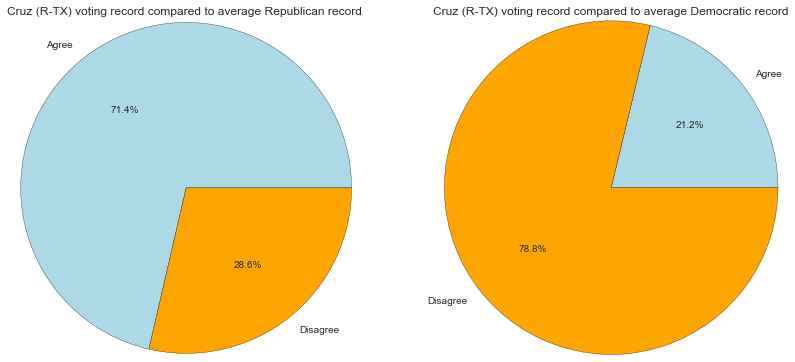

In [42]:
senators = df.ix[:,0:100]
dems = [col for col in senators.columns if col.split()[1][1] == 'D']
reps = [col for col in senators.columns if col.split()[1][1] == 'R']
other = [col for col in senators.columns if col.split()[1][1] not in 'DR']

all_senator_votes = senators.apply(lambda vote: vote == 'Yea')

def get_average_vote(senators):
    votes = all_senator_votes[senators]
    avg_vote = votes.mode(axis=1)[0]
    return avg_vote

df['DEM'] = get_average_vote(dems)
df['REP'] = get_average_vote(reps)

senator_votes = all_senator_votes[senator_name]
dem_inline_votes = df['DEM'] == senator_votes
rep_inline_votes = df['REP'] == senator_votes

dem_inline_percent = sum(dem_inline_votes / float(len(all_senator_votes)))
rep_inline_percent = sum(rep_inline_votes / float(len(all_senator_votes)))


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['lightblue', 'orange']

plt.pie([rep_inline_percent, 1-rep_inline_percent],
            labels=['Agree', 'Disagree'], colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title(senator_name + ' voting record compared to average Republican record')

plt.subplot(1, 2, 2)
plt.pie([dem_inline_percent, 1-dem_inline_percent],
            labels=['Agree', 'Disagree'], colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title(senator_name + ' voting record compared to average Democratic record')

plt.show()